# Ease of Use

*Max Zwiessele* 20th of September 2015

GPy is deveoped for the easy application of Gaussian process based analyses, for the user to not be confused by the complexity of some applications. This improves readability and prevents errors of scientific code of Gaussian process based applications. This platform is meant as a framework for your work evolving around GPs.

A model in GPy is an object with an objective function. If necessary, this object can include gradients w.r.t. its parameters, in order for gradient based optimizations to take place. The useability of GPy comes with its great power and handling of its parameters. The parameters of a model are always nameable, accessible and interchangeable.

We want to demonstrate the light handedness of GPys parameterized framework on a simple Gaussian process regression example in order to show how easy it is to generate an analysis flow in GPy.

In [1]:
import numpy as np, GPy, pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

For the purpose of this notebook we will use the regression task of the abalone dataset - the prediction of age of Abalone (edible snails) from physical measurements. 

We can download the dataset from http://www.cs.toronto.edu/%7Edelve/data/abalone/desc.html. For convenience we include alittle script which downloads the data and saves it locally as a pickle file. The data gets saved in this directory. When running the script it loads the data into a pandas data frame called `data`:

In [2]:
%run load_abalone
data.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
# Make training and test possible, by subsetting the data randomly. 
# We will use 1/8 of the data as training set:
train_idx = np.random.choice(data.shape[0], data.shape[0]/8)
test_idx = np.setdiff1d(np.arange(data.shape[0]), train_idx)[:400]
# make sex a categorical factor, for usage in regression task
_tmp = data.copy()
sex_labels, sex_uniques = pd.factorize(data['sex'], size_hint=3)
_tmp['sex'] = sex_labels
data_train, data_test = _tmp.loc[train_idx].copy(), _tmp.loc[test_idx].copy()

Now that we have the data, we can start writing a GP, with which we will show how you can manipulate and show the model easily. We will have one kernel for each input dimension, named after the data input. For starters we will use only one input, and expand. This will also show how easy it is to create complex GPy models and still have full access to all parameters and their settings.

In [4]:
# Select one input for now: we will use the diameter:
selected_input = 'length'
simple_kern = GPy.kern.Matern32(1, # How many dimension does this kernel have?
                                name=selected_input # The name of this kernel
                               )
# Try out different kernels and see how the output changes. 
# This process is called model selection, as the kernel
# represents the prior believe over function
# values of the output.

In [5]:
X_train = data_train.loc[:, 'sex':'shell_weight']
Y_train = data_train.loc[:, ['rings']]

X_test = data_test.loc[:, 'sex':'shell_weight']
Y_test = data_test.loc[:, ['rings']]

Note! Carefull with this next line on slow or low memory machines. We are running a GP on more then 2000 datapoints. If you are not sure, try modifying `GPRegression` into `SparseGPRegression`, which will load a memory and runtime efficient version of GPRegression. This will add additional parameters `inducing_input`, which are due to the sparse model.

In [6]:
simple_model = GPy.models.GPRegression(X_train.loc[:,[selected_input]].values, Y_train.values, kernel=simple_kern)

In [7]:
simple_model

GP_regression.,Value,Constraint,Prior,Tied to
length.variance,1.0,+ve,,
length.lengthscale,1.0,+ve,,
Gaussian_noise.variance,1.0,+ve,,


The first thing which we can see, is that the diameter kernel was added properly into the model and we can see its name in the output. 

In [8]:
# Optimize the simple model and plot the result
simple_model.optimize(messages=1)

 :0: FutureWarning:IPython widgets are experimental and may change in the future.


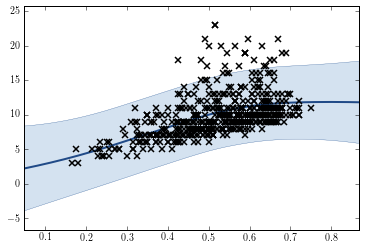

In [9]:
_ = simple_model.plot(plot_training_data=True)

As we can see, the GP can fit the data ok, although the noise on the data is clearly poisson distributed. You can try to run the Poisson regression on this data now (see e.g. [Posson regression](../GPy/Poisson regression tutorial.ipynb)). We will go on using more inputs and showing the parameter handling.

In [10]:
def log_likelihood(m, X_test, Y_test):
    import scipy as sp
    mu, var = m.predict(X_test, full_cov=True)
    return sp.stats.multivariate_normal.logpdf(Y_test.flatten(), mu.flatten(), var).sum()

def RMSE(m, X_test, Y_test):
    mu, var = m.predict(X_test, full_cov=False)
    return np.sqrt(((mu - Y_test)**2).mean())
    

In [11]:
result_df = pd.DataFrame(index=['Log-likelihood', 'Root-mean-squared-error'])
result_df['simple'] = [log_likelihood(simple_model, X_test[[selected_input]].values, Y_test.values), RMSE(simple_model, X_test[[selected_input]].values, Y_test.values)]

In [12]:
result_df

,simple
Log-likelihood,-1041.922000
Root-mean-squared-error,3.454917


We will now use the full data set, but will switch to a sparse GP for better performace.

In [13]:
# Create one kernel for each input dimension, except the categorical (sex) dimension:
kernels = []
for dim, name in enumerate(X_train.columns):
    if name != "sex":
        kernels.append(GPy.kern.Matern32(1, #input dim
                                         active_dims=[dim], # Dimension of X to work on
                                         name=name
                                        )
                      )
kern_numeric = reduce(lambda a,b: a+b, kernels)
kern_numeric.name = 'kernel'

In [14]:
kern_numeric

kernel.,Value,Constraint,Prior,Tied to
length.variance,1.0,+ve,,
length.lengthscale,1.0,+ve,,
diameter.variance,1.0,+ve,,
diameter.lengthscale,1.0,+ve,,
height.variance,1.0,+ve,,
height.lengthscale,1.0,+ve,,
whole_weight.variance,1.0,+ve,,
whole_weight.lengthscale,1.0,+ve,,
shucked_weight.variance,1.0,+ve,,
shucked_weight.lengthscale,1.0,+ve,,


Now we have a kernel over all input dimensions named in the right way. We can use this kernel in a `SparseGPRegression` model:

In [15]:
numerical_model = GPy.models.SparseGPRegression(X_train.values, Y_train.values, 
                                                kernel=kern_numeric, num_inducing=40)

In [16]:
numerical_model

sparse_gp.,Value,Constraint,Prior,Tied to
inducing inputs,"(40, 8)",,,
kernel.length.variance,1.0,+ve,,
kernel.length.lengthscale,1.0,+ve,,
kernel.diameter.variance,1.0,+ve,,
kernel.diameter.lengthscale,1.0,+ve,,
kernel.height.variance,1.0,+ve,,
kernel.height.lengthscale,1.0,+ve,,
kernel.whole_weight.variance,1.0,+ve,,
kernel.whole_weight.lengthscale,1.0,+ve,,
kernel.shucked_weight.variance,1.0,+ve,,


In [17]:
numerical_model.optimize(messages=1, max_iters=3e3)

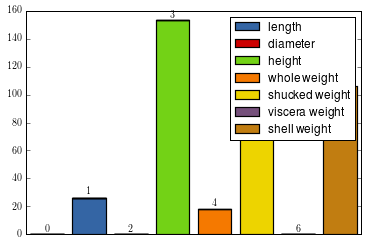

In [18]:
numerical_model.kern.plot_ARD()
plt.legend()

In [19]:
# Evaluate the log likelihood for the whole numerical model:
result_df['all numerics'] = [log_likelihood(numerical_model, X_test.values, Y_test.values),
          RMSE(numerical_model, X_test.values, Y_test.values)]

In [20]:
result_df

,simple,all numerics
Log-likelihood,-1041.922000,-988.787640
Root-mean-squared-error,3.454917,2.826234


When comparing to the model with only the one selected input we have a slight improvement in log likelihood evaluation. Now we have an additional input, which seperates the data into three different tasks. We can resolve different tasks in GPs using the so-called coregionalization technique.

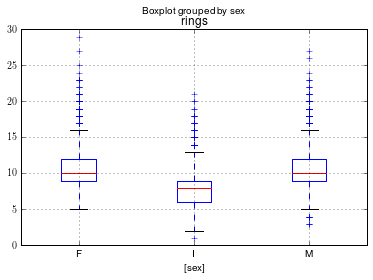

In [21]:
_ = data[['sex','rings']].boxplot(by='sex')

In order to add coregionalization to a model we merely have to create the right kernel, which understands the coregionalization structure in the data:

In [23]:
kern_coreg = GPy.kern.Coregionalize(1, # Dimensionality of coregionalize input
                                    len(sex_uniques), # How many different tasks do we have?
                                    rank=1, # How deep is the coregionaliztion
                                    active_dims=[X_train.columns.get_loc('sex')] ,
                                    # Which dimension of the input carries the task information?
                                    name = 'sex',
                                   ) * kern_numeric.copy()

In [24]:
full_model = GPy.models.SparseGPRegression(X_train.values, Y_train.values, kernel=kern_coreg, num_inducing=40)

In [25]:
full_model.optimize(messages=1, max_iters=3e3)

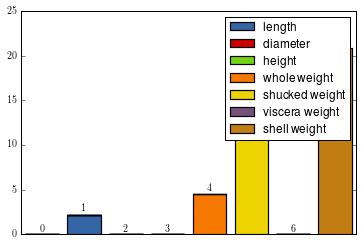

In [26]:
full_model.kern.kernel.plot_ARD()
_ = plt.legend()

In [27]:
# Evaluate the log likelihood for the whole numerical model with coregionalization:
result_df['coreg'] = [log_likelihood(full_model, X_test.values, Y_test.values),
      RMSE(full_model, X_test.values, Y_test.values)]

In [28]:
result_df

,simple,all numerics,coreg
Log-likelihood,-1041.922000,-988.787640,-984.413408
Root-mean-squared-error,3.454917,2.826234,2.780061


In this particular case we can see, that making the model more flexible by adding more inputs and priors leads to a better result, this is not necessarily true, as the model may get too flexible and overdoes the fitting of the data.

We have seen how easy it is to build a complex model around a dataset using GPy. As a last I want to show the comparison between all three models:

In [34]:
result_df.loc['neg-log-likelihood'] = -result_df.loc['Log-likelihood']

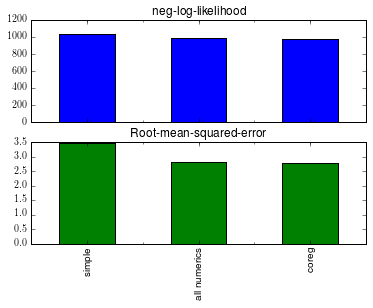

In [35]:
_ = result_df.T[['neg-log-likelihood', 'Root-mean-squared-error']].plot(kind='bar', subplots=True, legend=False)